Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :)
📓 This repository/notebook serves as a personal reminder for me, 
documenting code snippets and techniques sourced from various learning resources. 
The goal is to consolidate valuable information and create a basic reference guide. 
Please note that the codes included here are not originally mine, and credit goes 
to the respective authors and resources. Feel free to explore and 
use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/tree/master/Chapter02
    * https://www.kaggle.com/c/histopathologic-cancer-detection/data.
    
#### Purpose :
    * Binary classification by Pytorch with a kaggle dataset.
    
#### Keywords :
    * Exploring the dataset
    * Creating a custom dataset
    * Splitting the dataset
    * Transforming the data
    * Building the classification model
    * Training and evaluation of the model
    * Model inference on test data


Let's begin... First, what we have?? train and test folders with .tif images, and a train_labes.csv file for ground truth labels for train images

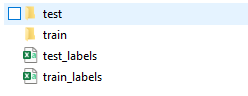

In [1]:
import pandas as pd 

path2csv="./data_binary/train_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


id : image file name 

label : 0 or 1 (1 for malignant)

time to explore dataset

In [2]:
print(labels_df['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


<Axes: >

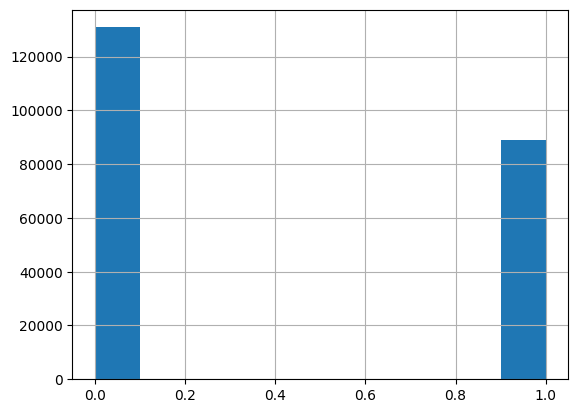

In [3]:
labels_df['label'].hist()

'' ... visualize a few images that have a positive label. A positive label shows that
the center 32 x 32 region of an image contains at least one pixel of tumor tissue....''

In [4]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os

In [12]:
# data is stored here
path2train="./data_binary/train/"

In [5]:


# get ids for malignant images
# check for labels from labels_df.. if the label==1 then add its 'id' value
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

In [6]:
malignantIds

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f', ...,
       '309210db7f424edbc22b2d13bf2fa27518b18f5c',
       'd4b854fe38b07fe2831ad73892b3cec877689576',
       'a81f84895ddcd522302ddf34be02eb1b3e5af1cb'], dtype=object)

In [7]:
malignantIds.shape

(89117,)

In [8]:
type(malignantIds)

numpy.ndarray

- show the first 9 images from malignantIds
- show them in a 3x3 matrix
- add a green rectangle to show tissue
- color parameter for grayscale or colorful images

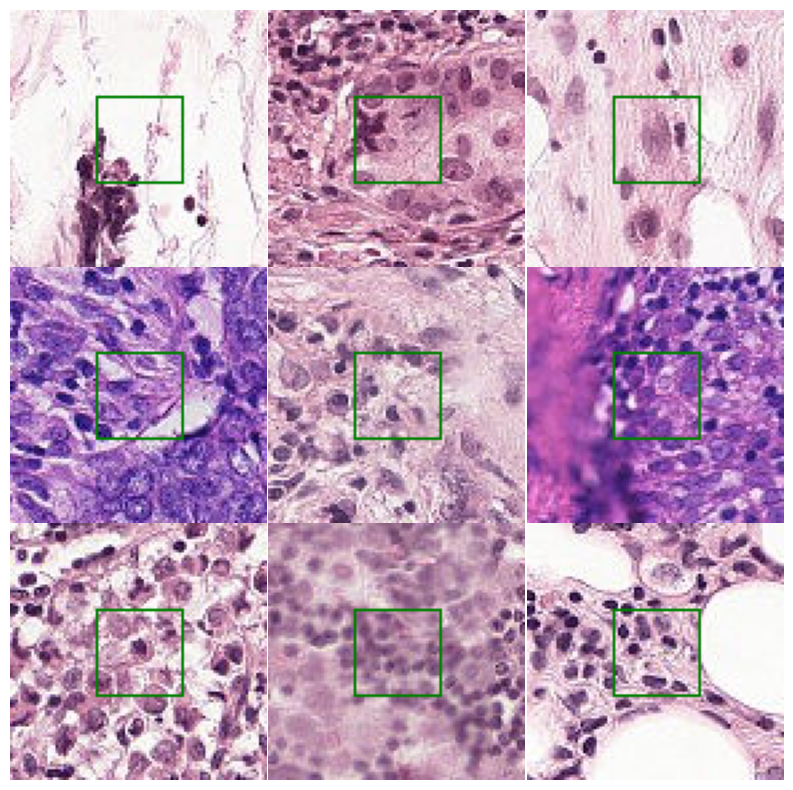

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3
color=True
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")

    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [14]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


#### Creating a custom dataset

'' A traditional method for working with a dataset would be to load all images into NumPy
arrays. Since we are dealing with a relatively large dataset, this would be a waste of our
computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch
has a powerful tool to handle large datasets....

When creating a custom Dataset class, make sure to define two essential functions: (_ _len_ _) and
_ _getitem_ _. The _ _len_ _ function returns the dataset's length. This function is callable
with the Python len function. The _ _getitem_ _ function returns an image at the specified
index...''

In [15]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)

In [16]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [17]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [18]:
data_dir = "./data_binary/"

In [19]:
histo_dataset = CancerDataset(data_dir, data_transformer, "train")

In [20]:
print(len(histo_dataset))

220025


In [21]:
# load an image
img,label=histo_dataset[9]

In [22]:
img

tensor([[[0.7216, 0.6157, 0.5294,  ..., 0.8824, 0.8863, 0.8863],
         [0.7490, 0.5961, 0.5961,  ..., 0.8863, 0.8863, 0.8902],
         [0.6000, 0.6980, 0.5843,  ..., 0.8902, 0.8784, 0.8784],
         ...,
         [0.6627, 0.7686, 0.8627,  ..., 0.5725, 0.8588, 0.6157],
         [0.7686, 0.9647, 0.7333,  ..., 0.5804, 0.8588, 0.6745],
         [0.5804, 0.9647, 0.9373,  ..., 1.0000, 0.8000, 0.6941]],

        [[0.3255, 0.2392, 0.1843,  ..., 0.8863, 0.8902, 0.8902],
         [0.4510, 0.2980, 0.2980,  ..., 0.8824, 0.8824, 0.8863],
         [0.4235, 0.5020, 0.3490,  ..., 0.8706, 0.8706, 0.8706],
         ...,
         [0.2941, 0.4392, 0.5804,  ..., 0.3255, 0.5804, 0.3412],
         [0.3961, 0.6353, 0.4510,  ..., 0.3216, 0.5451, 0.3451],
         [0.2039, 0.6314, 0.6471,  ..., 0.7412, 0.4667, 0.3333]],

        [[0.6235, 0.5294, 0.4824,  ..., 0.8941, 0.8980, 0.8980],
         [0.7333, 0.5804, 0.5882,  ..., 0.9020, 0.9020, 0.9059],
         [0.6863, 0.7725, 0.6314,  ..., 0.8941, 0.8902, 0.

In [23]:
img.shape

torch.Size([3, 96, 96])

In [24]:
label

1

In [25]:
print(torch.min(img),torch.max(img))

tensor(0.) tensor(1.)


!!! '' This is the result of transforms.
ToTensor() converts a PIL image into the range [0, 255] to torch.FloatTensor of
shape (C x H x W) in the range [0.0, 1.0]. '' !!!

- split our dataset for train and validation

In [26]:
len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

In [27]:
print(len_train,len_val)

176020 44005


In [29]:
from torch.utils.data import random_split

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


an example from each dataset

In [30]:
train_ds

In [31]:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [32]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [33]:
# define a func for showing an image from dataset and show label

def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

In [34]:
## select 4 random images from train dataset and show them with labels
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

image indices: [30432 61610 91636 47509]


In [35]:
train_ds[0]

(tensor([[[0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9725, 0.9765],
          [0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9725, 0.9765],
          [0.9686, 0.9686, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          ...,
          [0.9686, 0.9725, 0.9725,  ..., 0.9608, 0.9608, 0.9569],
          [0.9647, 0.9647, 0.9686,  ..., 0.9686, 0.9529, 0.9569],
          [0.9569, 0.9608, 0.9608,  ..., 0.9608, 0.9686, 0.9804]],
 
         [[0.9686, 0.9686, 0.9686,  ..., 0.9608, 0.9647, 0.9686],
          [0.9686, 0.9686, 0.9686,  ..., 0.9608, 0.9647, 0.9686],
          [0.9686, 0.9686, 0.9686,  ..., 0.9569, 0.9608, 0.9647],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.9569, 0.9765, 0.9804],
          [0.9647, 0.9647, 0.9725,  ..., 0.9686, 0.9569, 0.9725],
          [0.9608, 0.9686, 0.9725,  ..., 0.9608, 0.9647, 0.9765]],
 
         [[0.9686, 0.9686, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          [0.9686, 0.9686, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          [0.9686, 0.9686, 0.9686,  ...,

In [37]:
len(train_ds[0])

2

One of them is the array for image, other one is the label!!
because of that... We will collect image data to x_grid and label data to y_grid while showing them


In [38]:
x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

In [39]:
x_grid_train

[tensor([[[0.8824, 0.7451, 0.6471,  ..., 0.8431, 0.6235, 0.6196],
          [0.8902, 0.7412, 0.7137,  ..., 0.3843, 0.6863, 0.6353],
          [0.8392, 0.9608, 0.6588,  ..., 0.1255, 0.5843, 0.9176],
          ...,
          [0.7922, 0.6667, 0.9804,  ..., 0.1647, 0.3020, 0.3333],
          [0.6667, 0.7059, 0.7529,  ..., 0.1608, 0.1961, 0.1882],
          [0.4392, 0.4980, 0.5412,  ..., 0.3373, 0.2824, 0.1216]],
 
         [[0.5725, 0.4353, 0.3490,  ..., 0.6902, 0.4667, 0.4510],
          [0.6000, 0.4510, 0.4275,  ..., 0.2314, 0.5255, 0.4784],
          [0.5529, 0.6863, 0.3922,  ..., 0.0000, 0.4275, 0.7647],
          ...,
          [0.5333, 0.4118, 0.7333,  ..., 0.0000, 0.1490, 0.1882],
          [0.4196, 0.4549, 0.5020,  ..., 0.0078, 0.0627, 0.0706],
          [0.2039, 0.2588, 0.2902,  ..., 0.1961, 0.1647, 0.0235]],
 
         [[0.6863, 0.5490, 0.4588,  ..., 0.7961, 0.5686, 0.5569],
          [0.7059, 0.5569, 0.5333,  ..., 0.3529, 0.6431, 0.5843],
          [0.6588, 0.7882, 0.4902,  ...,

In [41]:
len(x_grid_train)

4

In [42]:
y_grid_train

[0, 0, 0, 0]

In [44]:
from torchvision import utils

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

torch.Size([3, 100, 394])


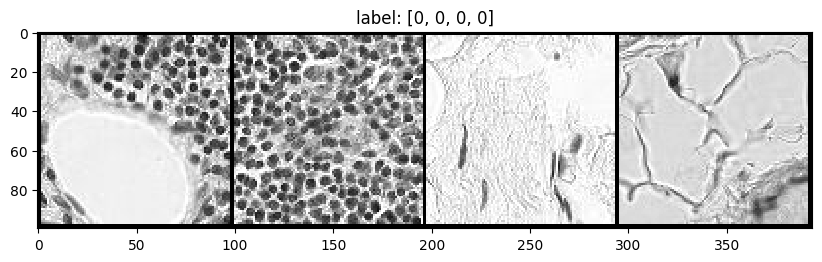

In [45]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

... and also for validation set

image indices: [35035 10827 16764 43842]
torch.Size([3, 100, 394])


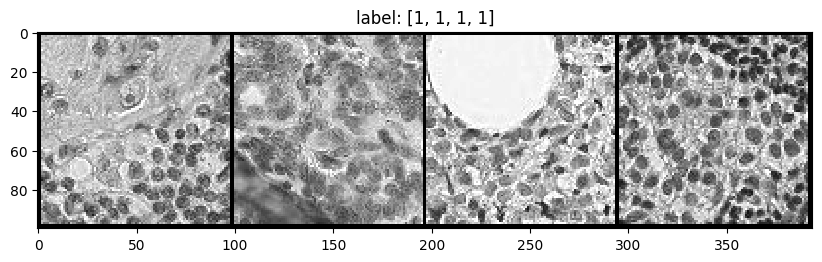

In [46]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

### Transform Data

In [47]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [48]:
# no need for validation dataset
val_transformer = transforms.Compose([transforms.ToTensor()])  

In [49]:
train_ds

In [50]:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

### Create Dataloader

'' ...We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write
code to loop over datasets and extract a data batch. This process can be made automatically
using a PyTorch Dataloader.''

In [52]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False) 

In [53]:
train_dl

In [54]:
# extract a batch from trainin data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [55]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


''...The batch size determines the number of images to be extracted from the dataset in each iteration. The
typical values of the batch size for classification tasks are in the range of [8-128]. Also, note
that we do not need to shuffle the validation data during evaluation.
If your computer or the GPU device on your computer does not have enough memory, you can reduce the batch size to avoid memory errors.''

In [57]:
len(train_ds)

176020

In [58]:
len(train_dl)

5501

In [59]:
176020/32

5500.625

our dataset is ready for training.. now let's build our model

### Building Classification Model

our model : 4 CNN layers and 2 FCN layers

we will implement a helper function to calculate the output size of a CNN layer, because the dimension of input of CNN layers are important for us

In [60]:
import torch.nn as nn

def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


check this func.

In [61]:
# example input image is 96x96 
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


now we can define our model

In [62]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        #The linear layer accepts a 2D tensor. That is why we need the view method in the forward function to reshape the 4D tensor
        #into a 2D tensor:
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'' How do we get the value of self.num_flatten? Well, PyTorch does not automatically
calculate this value. It is our duty to find this value and provide it to the linear layer. One
approach would be to print (x.size()) to get the output shape of each layer.
The other option is using the findConv2DOutShape function. The output size of the fourth
CNN layer (together with the pooling layer) is h,w and there are 8*init_f output
channels. Therefore, after flattening, we get self.num_flatten=hxwx8xinit_f.

The last layer is F.log_softmax(x, dim=1) (with two outputs), which is equivalent to log(softmax(x)). if we want to get the output probability value, we need to use the exponential operation. ''

In [63]:
# dict to define model parameters
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }

In [64]:
# create model
cnn_model = Net(params_model)

In [65]:
cnn_model

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [66]:
# move model to cuda/gpu device
print(torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

True


In [67]:
print(next(cnn_model.parameters()).device)

cuda:0


In [68]:
print(next(cnn_model.parameters()))

Parameter containing:
tensor([[[[ 1.8810e-01,  2.1450e-02, -9.6350e-03],
          [ 5.5026e-02, -1.1746e-01, -6.6436e-02],
          [ 4.1785e-02,  5.7628e-02,  1.8650e-01]],

         [[ 9.3394e-03,  1.5184e-01,  1.3706e-01],
          [ 3.2211e-02, -1.3656e-01, -1.1038e-01],
          [ 1.2444e-01, -1.8084e-01,  5.1042e-02]],

         [[ 1.8531e-01, -1.3001e-01, -1.0708e-01],
          [-1.8830e-01,  1.6716e-01,  4.0178e-02],
          [ 4.0006e-02, -1.7014e-01, -1.4538e-01]]],


        [[[-9.4404e-02,  1.5789e-02,  1.7619e-01],
          [ 3.9806e-02,  1.6608e-01,  3.5438e-02],
          [ 1.1100e-01,  2.0556e-02,  1.7131e-01]],

         [[ 1.3226e-01, -1.3022e-01, -1.6284e-01],
          [ 1.1413e-01,  9.0724e-02,  1.1730e-01],
          [ 9.3237e-02,  1.0517e-01, -7.0609e-03]],

         [[-1.7038e-01, -4.4875e-02,  6.6503e-02],
          [-1.4825e-01,  1.3326e-01, -1.6775e-01],
          [-1.6037e-01, -2.0817e-02, -1.4082e-01]]],


        [[[-1.4260e-01, -1.4432e-01, -2.1686

In [69]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


### Defining the loss function

'' The standard loss function for classification tasks is cross-entropy loss or logloss. However,
when defining the loss function, we need to consider the number of model outputs and
their activation functions. For binary classification tasks, we can choose one or two outputs.'' 

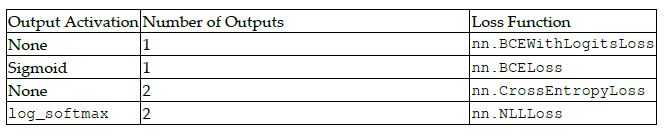

'' We recommend using the log_softmax function as it is easier to expand to multi-class
classification. PyTorch combines the log and softmax operations into one function due to
numerical stability and speed.''

In [70]:
loss_func = nn.NLLLoss(reduction="sum")

In [71]:
# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [72]:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


### Defining the optimizer

In [73]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [74]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


!!! In PyTorch, we can set a different learning rate per
layer, but in this chapter, we'll choose to set one learning rate for all the layers. In!!!

In [75]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [76]:
for i in range(100):
    lr_scheduler.step(1)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


### Training and Evaluation

In [77]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [78]:
n,c=8,2
output = torch.randn(n, c, requires_grad=True)
print (output)
print(output.shape)

tensor([[ 0.4681, -0.1577],
        [ 1.4437,  0.2660],
        [ 0.1665,  0.8744],
        [-0.1435, -0.1116],
        [ 0.9318,  1.2590],
        [ 2.0050,  0.0537],
        [ 0.6181, -0.4128],
        [-0.8411, -2.3160]], requires_grad=True)
torch.Size([8, 2])


In [79]:
#target = torch.randint(c,size=(n,))
target = torch.ones(n,dtype=torch.long)
print(target.shape)

torch.Size([8])


In [80]:
target

tensor([1, 1, 1, 1, 1, 1, 1, 1])

In [81]:
metrics_batch(output,target)

3

In [82]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [83]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [84]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [85]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models_binary/weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000124, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 1/99, current lr=0.0003
train loss: 0.000124, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 2/99, current lr=0.0003
train loss: 0.000124, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 3/99, current lr=0.0003
train loss: 0.000126, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 4/99, current lr=0.0003
train loss: 0.000120, dev loss: 0.001022, accuracy: 0.07
----------
Epoch 5/99, current lr=0.0003
train loss: 0.000124, dev loss: 0.001023, accuracy: 0.07
----------
Epoch 6/99, current lr=0.0003
train loss: 0.000122, dev loss: 0.001026, accuracy: 0.07
----------
Epoch 7/99, current lr=0.0003
train loss: 0.000116, dev loss: 0.001029, accuracy: 0.07
----------
Epoch 8/99, current lr=0.0003
train loss: 0.000118, dev loss: 0.001030, accuracy: 0.07
----------
Epoch 9/99, current lr=0.0003
train loss: 0.000129, dev loss: 0.001035, accuracy: 0.07
----

train loss: 0.000123, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 81/99, current lr=3.75e-05
train loss: 0.000123, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 82/99, current lr=3.75e-05
train loss: 0.000122, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 83/99, current lr=3.75e-05
train loss: 0.000122, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 84/99, current lr=3.75e-05
train loss: 0.000124, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 85/99, current lr=3.75e-05
train loss: 0.000126, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 86/99, current lr=3.75e-05
train loss: 0.000126, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 87/99, current lr=3.75e-05
train loss: 0.000119, dev loss: 0.001020, accuracy: 0.07
----------
Epoch 88/99, current lr=3.75e-05
train loss: 0.000124, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 89/99, current lr=3.75e-05
train loss: 0.000124, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 90/99, current lr

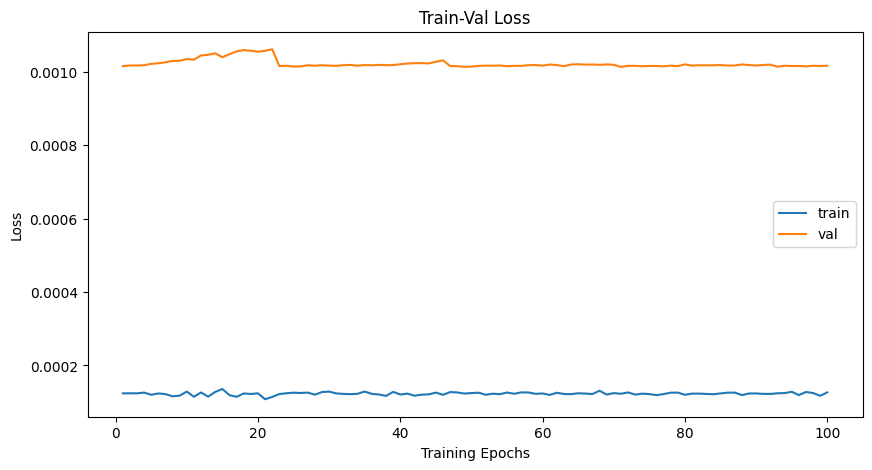

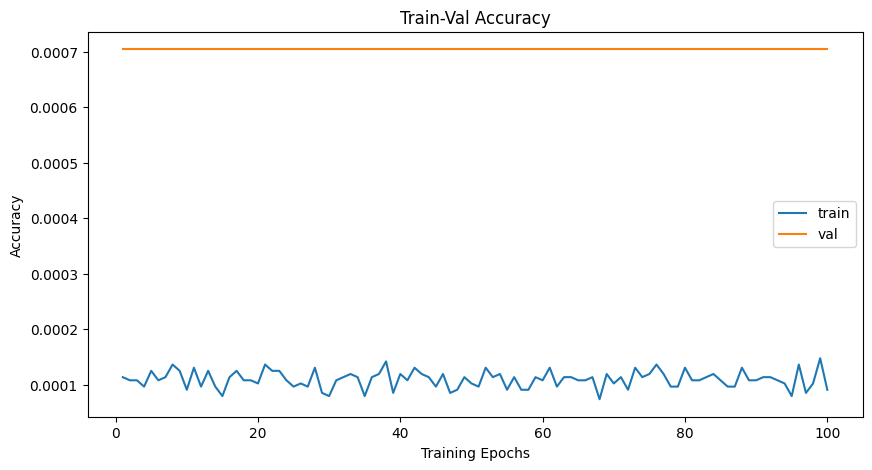

In [86]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

!!!! that was a Senity Check, don't worry about values. It is just a quick control !!!!

In [87]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models_binary/weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/1, current lr=0.0003
Copied best model weights!
train loss: 0.439969, dev loss: 0.413228, accuracy: 81.42
----------
Epoch 1/1, current lr=0.0003
Copied best model weights!
train loss: 0.371665, dev loss: 0.348988, accuracy: 84.70
----------


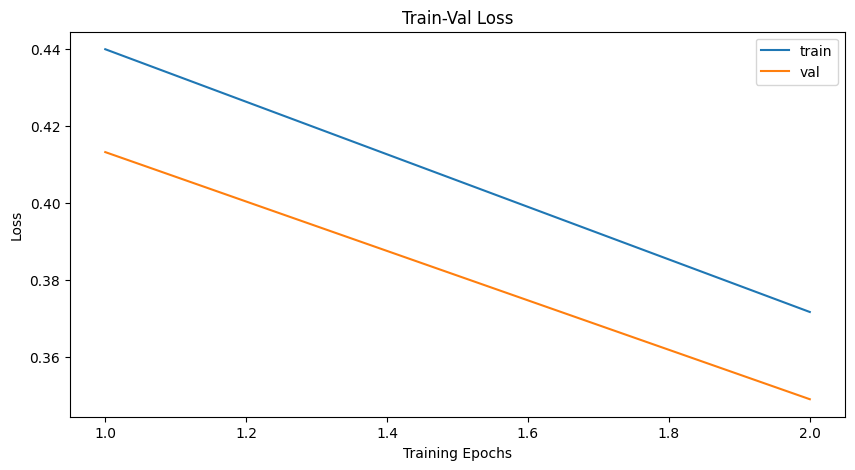

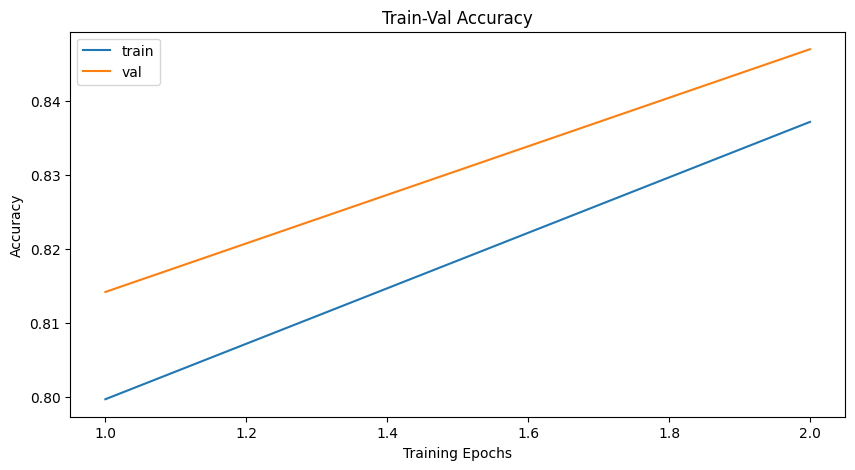

In [88]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### Deploy Model on Test dataset

'' We assume that you want to deploy the model for inference in a new script that's separate
from the training scripts. In this case, the model and weights do not exist in memory.
Therefore, we need to construct an object of the model class and load the weights into the
model.''

In [89]:
import torch.nn as nn
import numpy as np
np.random.seed(0)


In [90]:
import torch.nn as nn
import torch.nn.functional as F


def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [91]:
# model parameters
params_model={
 "input_shape": (3,96,96),
 "initial_filters": 8, 
 "num_fc1": 100,
 "dropout_rate": 0.25,
 "num_classes": 2,
 }

# initialize model
cnn_model = Net(params_model)

In [92]:
import torch

path2weights="./models_binary/weights.pt"
# load state_dict into model
cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [93]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [94]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device) 

In [95]:
import time 
def deploy_model(model,dataset,device, num_classes=2,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [96]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get a list of images
        self.filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename=data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [97]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [98]:
data_dir = "./data_binary/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [99]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [100]:
# deploy model 
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 0.93 ms 
(44005, 2) (44005,)


In [102]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.85


### Deploy on CPU

In [103]:
# deploy model on cpu
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cpu: 1.26 ms 
(44005, 2) (44005,)


### Model Inference on Test Data

In [105]:
histo_test = histoCancerDataset(data_dir, data_transformer,data_type="test")
print(len(histo_test))

57458


In [106]:
y_test_out,_=deploy_model(cnn_model,histo_test, device, sanity_check=False)


y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

average inference time per image on cuda: 0.98 ms 
(57458,)


image indices: [ 2732 43567 42613 52416]
torch.Size([3, 100, 394])


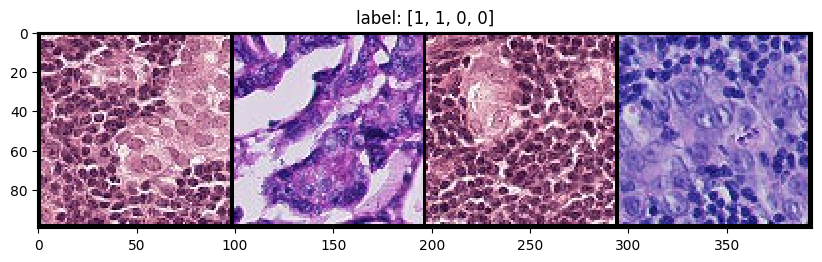

In [107]:
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)


def show(img,y,color=True):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))
    
grid_size=4
rnd_inds=np.random.randint(0,len(histo_test),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)